***Data Pre-Processor***


In [1]:
%run DeepFake_Dataloader.py
%run utils.py

In [2]:
import h5py
import torch
import numpy as np

In [3]:
batch_sz = 128 
dataloader = get_preprocessors(batch_size=batch_sz)
total_imgs = len(dataloader) * batch_sz
print(total_imgs)

('Classes: '
 "['lsun_cats', "
 "'lsun_churches', "
 "'stylegan2_cats', "
 "'stylegan2_churches']")
('Indices: '
 "{'lsun_cats': 0, "
 "'lsun_churches': "
 '1, '
 "'stylegan2_cats': "
 '2, '
 "'stylegan2_churches': "
 '3}')
40064


In [4]:
progress = ProgressMonitor(length=total_imgs)
with h5py.File('LSUN_256.hdf5', 'w') as f:
    """
        Create HDF5 datasets 
    """
    data_dset = f.create_dataset('fft_data',  (total_imgs, 182), dtype='f')
    lbl_dset  = f.create_dataset('lbl_data',  (total_imgs,),     dtype='i')
    orgn_dset = f.create_dataset('orgn_data', (total_imgs,),     dtype='i')
    img_size  = f.create_dataset('img_size',  (total_imgs,),     dtype='i')
    data_size = f.create_dataset('data_size', (total_imgs,),     dtype='i')
    
    for i, (img_data, target, origin_dataset) in enumerate(dataloader):
        start_idx = i * batch_sz
        for j in range(img_data.shape[0]):
            idx = start_idx + j
            progress.update(1, 0)
            if (target[j] > 1):
                print(target[j])
            data_dset[idx] = img_data[j]
            lbl_dset[idx]  = target[j]
            orgn_dset[idx] = data_origin[origin_dataset[j]]
            img_size[idx]  = data_img_size[origin_dataset[j]]
            data_size[idx] = rad_size[origin_dataset[j]]

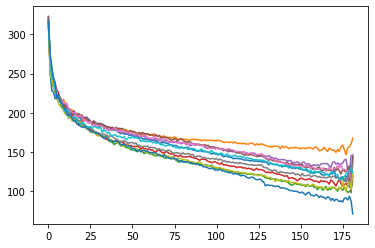

In [5]:
import matplotlib.pyplot as plt


with h5py.File('LSUN_256.hdf5', 'r') as f:
    dset = f['fft_data']
    plt.plot(dset[200])
    for i in range(10):
        plt.plot(dset[np.random.randint(20000)])
#         plt.show()
    plt.show()

In [7]:
with h5py.File('LSUN_Cars.hdf5', 'r') as f:
    dset = f['lbl_data']
    for i in range(len(dset)):
        if dset[i] != 1 and dset[i] != 0:
            print(dset[i])